# Практическое задание к уроку "GAN Pytorch"

1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики


In [31]:
import torch
import matplotlib.pyplot as plt

In [32]:
DATA_LENGTH = 1000

## Генерируем векторы X и y

In [33]:
X = torch.linspace(-20, 20, DATA_LENGTH)
y = torch.sin(X) / X - X / 10

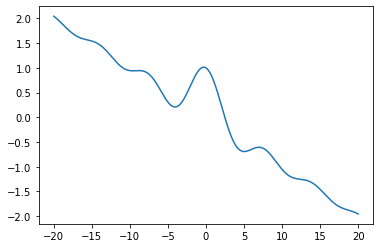

In [34]:
plt.plot(X.numpy(), y.numpy())

In [35]:
BATCH_SIZE = 4
img_shape = 1

## Создаем Dataset

In [36]:
dataset = torch.utils.data.TensorDataset(X, y)

In [37]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,)

## Создаем генератор и дискриминатор

In [38]:
import torch.nn as nn
import torch.nn as functional
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
device

'cpu'

In [41]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [42]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса как параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные 
        # на транспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [43]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.reshape(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

## Данные и классы созданы, обучим генератор и дискриминатор

In [105]:
n_epochs = 10  # количество эпох
lr = 0.005  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = DATA_LENGTH  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 200  # количество итераций для отображения процесса обучения

In [106]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

<Figure size 432x288 with 0 Axes>

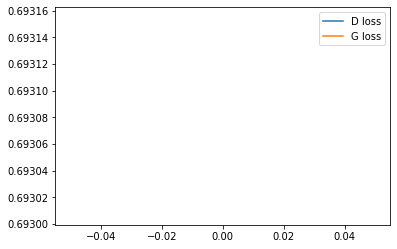

<Figure size 432x288 with 0 Axes>

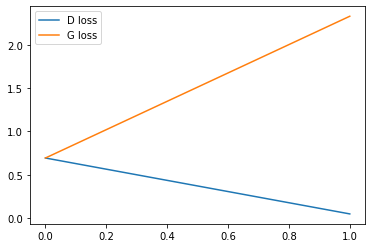

<Figure size 432x288 with 0 Axes>

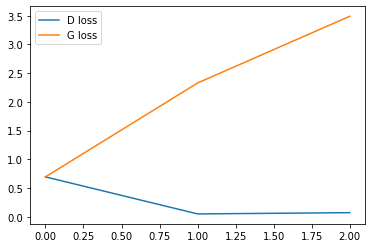

<Figure size 432x288 with 0 Axes>

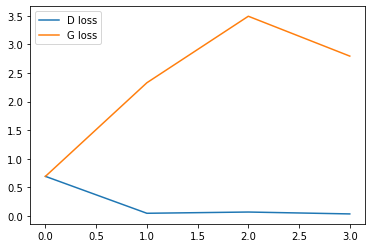

<Figure size 432x288 with 0 Axes>

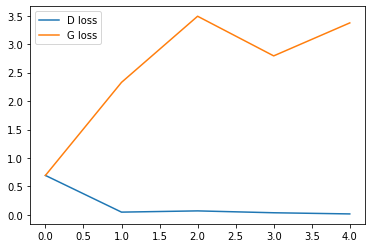

<Figure size 432x288 with 0 Axes>

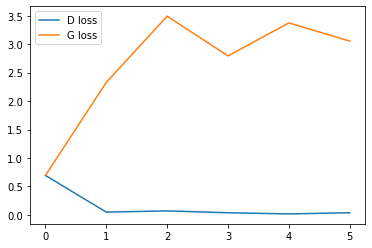

<Figure size 432x288 with 0 Axes>

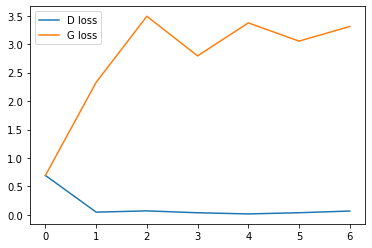

<Figure size 432x288 with 0 Axes>

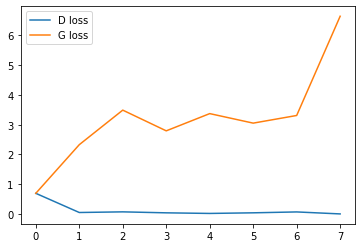

<Figure size 432x288 with 0 Axes>

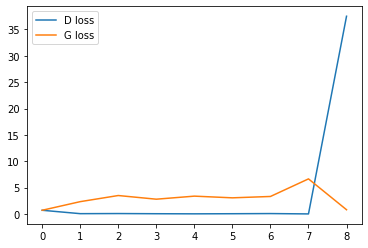

<Figure size 432x288 with 0 Axes>

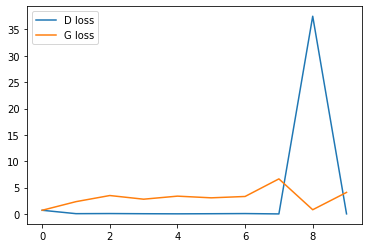

<Figure size 432x288 with 0 Axes>

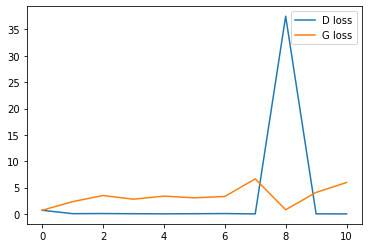

<Figure size 432x288 with 0 Axes>

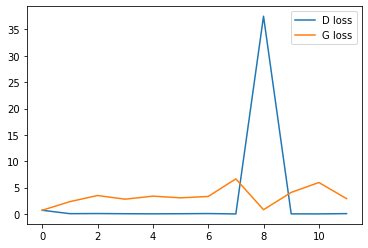

<Figure size 432x288 with 0 Axes>

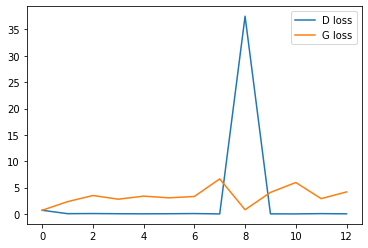

In [107]:
import matplotlib.patches as mpatches

d_loss_history = []
g_loss_history = []

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = torch.FloatTensor(BATCH_SIZE, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(BATCH_SIZE, 1).fill_(0.0).to(device)

        real_imgs = imgs.type(torch.FloatTensor).to(device)

        # Генерация шума
        noise = torch.FloatTensor(np.random.normal(0, 19, (BATCH_SIZE, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_imgs = generator(noise)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_imgs)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        noise = torch.FloatTensor(np.random.normal(0, 19, (BATCH_SIZE, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_imgs = generator(noise)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_imgs)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(dataloader) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                # sample_image(gen_imgs)
                # print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}]", end='|')
                # print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 

                # display.display(plt.gcf())
                plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()

                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()        